<a href="https://colab.research.google.com/github/VstCodes/Social_Engineering_Email_Detection_System/blob/main/security_proje_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

file_path = "/content/security_final_project_training_data.xlsx"
df = pd.read_excel(file_path)

# Step 1: Drop rows where the 'text' field is missing
df_clean = df.dropna(subset=['text']).copy()

# Step 2: Convert the 'category' string into a list of labels
df_clean['label_list'] = df_clean['category'].apply(lambda x: [label.strip() for label in x.split(',')])

# Step 3: Binarize the multi-label categories using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
label_matrix = mlb.fit_transform(df_clean['label_list'])

# Create a DataFrame from the binary label matrix
df_labels = pd.DataFrame(label_matrix, columns=mlb.classes_)

# Step 4: Combine the original text column with the new binary label columns
df_clean = df_clean.reset_index(drop=True)
df_processed = pd.concat([df_clean[['text']], df_labels], axis=1)

# Display the first few rows of the preprocessed dataset
df_processed.head(100)

,text,authority,impersonation,persuasion,safe email,urgency
0,Free entry in 2 a wkly comp to win FA Cup fina...,0,0,1,0,0
1,FreeMsg Hey there darling it's been 3 week's n...,0,0,1,0,1
2,WINNER!! As a valued network customer you have...,0,0,1,0,0
3,Had your mobile 11 months or more? U R entitle...,0,0,1,0,0
4,"SIX chances to win CASH! From 100 to 20,000 po...",0,0,1,0,0
...,...,...,...,...,...,...
95,1000's flirting NOW! Txt GIRL or BLOKE & ur NA...,0,0,0,0,1
96,EASTENDERS TV Quiz. What FLOWER does DOT compa...,0,0,1,0,1
97,We have new local dates in your area - Lots of...,0,0,0,0,1
98,Someone U know has asked our dating service 2 ...,0,0,0,0,1


<Axes: title={'center': 'Label Distribution'}, xlabel='label_list'>

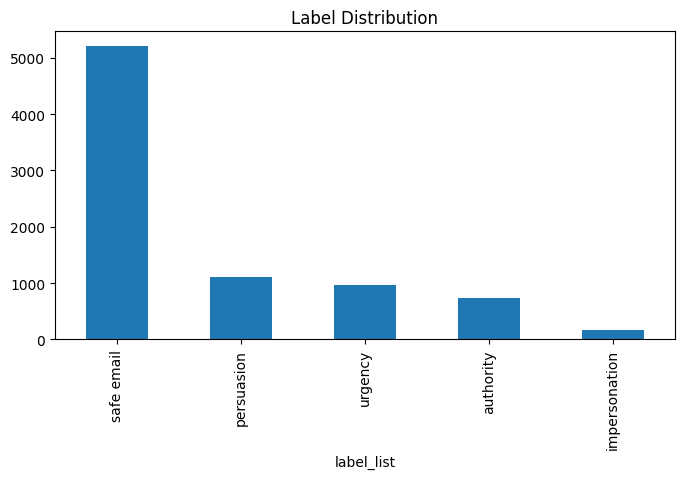

In [97]:
import pandas as pd

df_clean['label_list'].explode().value_counts().plot(kind='bar', title='Label Distribution', figsize=(8,4))

In [53]:
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 5: Text cleaning function
def clean_text(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        return ""  # Return an empty string or handle as appropriate

    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to the 'text' column
df_processed['clean_text'] = df_processed['text'].apply(clean_text)

# Step 6: Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust feature size as needed
X = vectorizer.fit_transform(df_processed['clean_text'])

# Step 7: Extract the binary labels
y = df_processed[['authority', 'impersonation', 'persuasion', 'safe email', 'urgency']]

# Step 8: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6124, 5000)
y_train shape: (6124, 5)
X_test shape: (1531, 5000)
y_test shape: (1531, 5)


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Metinleri al
X_raw = df_processed['text'].astype(str) # Convert to string type

# TF-IDF uygulama
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
X_tfidf = tfidf.fit_transform(X_raw)

In [55]:
# Select only the label columns for y
y = df_processed[['authority', 'impersonation', 'persuasion', 'safe email', 'urgency']]

In [56]:
from sklearn.model_selection import train_test_split

# %80 eğitim, %20 test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


# LOGISTIC REGRESSION

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 9: Define the model using OneVsRest strategy with class_weight='balanced'
model = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))

# Step 10: Train the model
model.fit(X_train, y_train)

# Step 11: Make predictions
y_pred = model.predict(X_test)

# Step 12: Evaluate model performance
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=y.columns))

# Optional: Accuracy per label
for idx, col in enumerate(y.columns):
    acc = accuracy_score(y_test[col], y_pred[:, idx])
    print(f"Accuracy for {col}: {acc:.2f}")


Classification Report:

               precision    recall  f1-score   support

    authority       0.80      0.94      0.87       159
impersonation       0.53      1.00      0.69        33
   persuasion       0.86      0.97      0.91       229
   safe email       0.98      0.99      0.98      1009
      urgency       0.80      0.92      0.86       219

    micro avg       0.91      0.97      0.94      1649
    macro avg       0.80      0.96      0.86      1649
 weighted avg       0.92      0.97      0.94      1649
  samples avg       0.94      0.97      0.95      1649

Accuracy for authority: 0.97
Accuracy for impersonation: 0.98
Accuracy for persuasion: 0.97
Accuracy for safe email: 0.98
Accuracy for urgency: 0.96


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-107-2749941971>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1, palette="viridis")


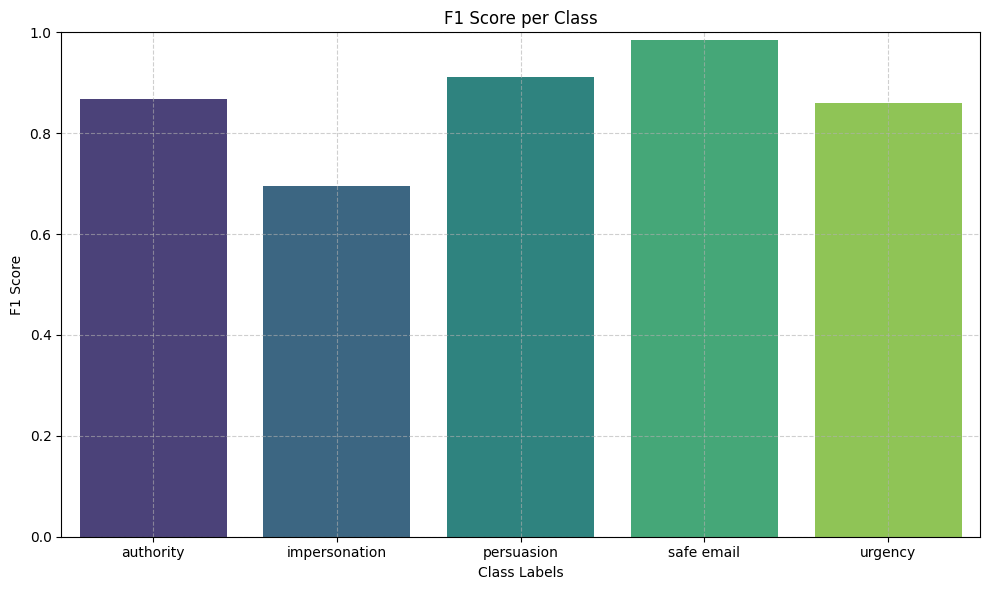

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 13: Calculate evaluation metrics per label
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

labels = y.columns

# Step 14: Plot F1-score per class
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=f1, palette="viridis")
plt.title("F1 Score per Class")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.xlabel("Class Labels")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


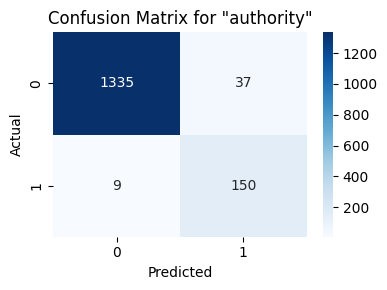

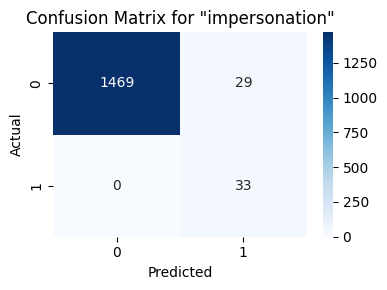

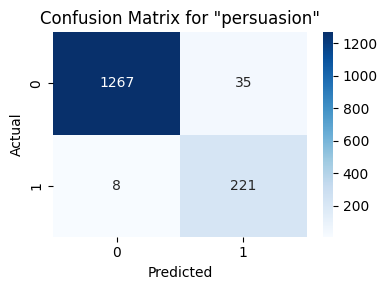

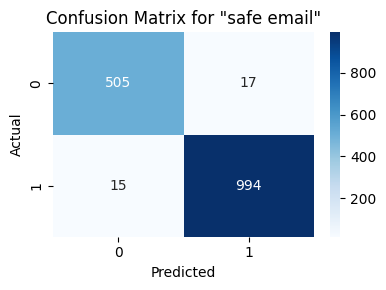

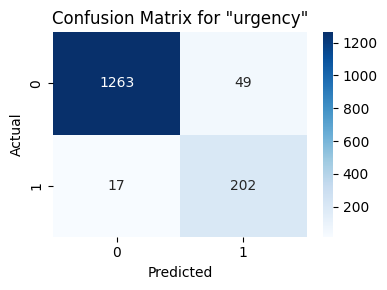

In [108]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Step 15: Plot confusion matrix per label
for idx, label in enumerate(labels):
    cm = confusion_matrix(y_test[label], y_pred[:, idx])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for "{label}"')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


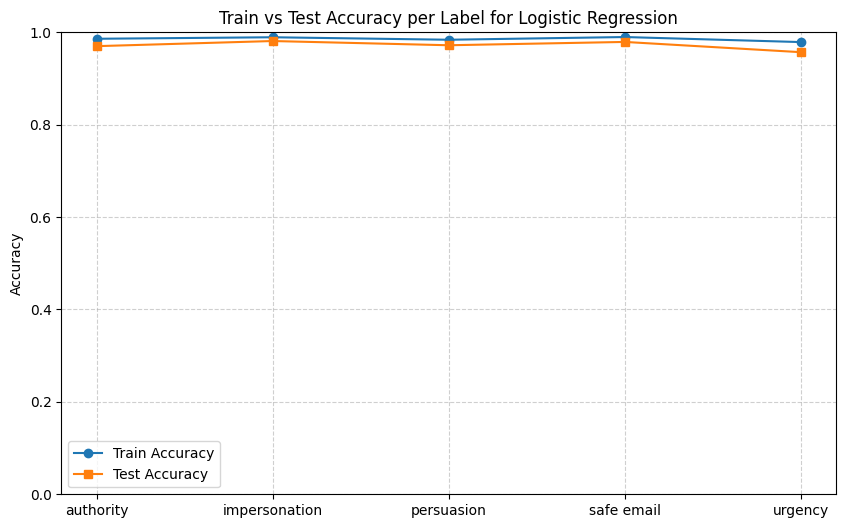

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

def plot_accuracy_line(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    labels = y.columns
    train_acc = []
    test_acc = []

    for idx, label in enumerate(labels):
        train_acc.append(accuracy_score(y_train[label], y_train_pred[:, idx]))
        test_acc.append(accuracy_score(y_test[label], y_test_pred[:, idx]))

    x = np.arange(len(labels))

    plt.figure(figsize=(10,6))
    plt.plot(x, train_acc, marker='o', label='Train Accuracy')
    plt.plot(x, test_acc, marker='s', label='Test Accuracy')

    plt.xticks(x, labels)
    plt.ylim(0,1)
    plt.ylabel('Accuracy')
    plt.title(f'Train vs Test Accuracy per Label for {model_name}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# Kullanımı:
plot_accuracy_line(model, X_train, y_train, X_test, y_test, "Logistic Regression")


In [92]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Skorlayıcı olarak micro-averaged F1-score kullan (multi-label için daha uygun)
f1_scorer = make_scorer(f1_score, average='micro')

# Modeli tanımla
model_logistic = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Cross-validation uygula (5 katlı)
scores = cross_val_score(model_logistic, X, y, cv=5, scoring=f1_scorer)

# Sonuçları yazdır
print("Cross-Validation F1 Scores:", scores)
print("Mean F1 Score:", scores)


Cross-Validation F1 Scores: [0.05088757 0.9292998  0.99901929 0.99869281 0.91346825]
Mean F1 Score: [0.05088757 0.9292998  0.99901929 0.99869281 0.91346825]


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-91-2133932301>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_f1_scores.index, y=label_f1_scores.values, palette="coolwarm")


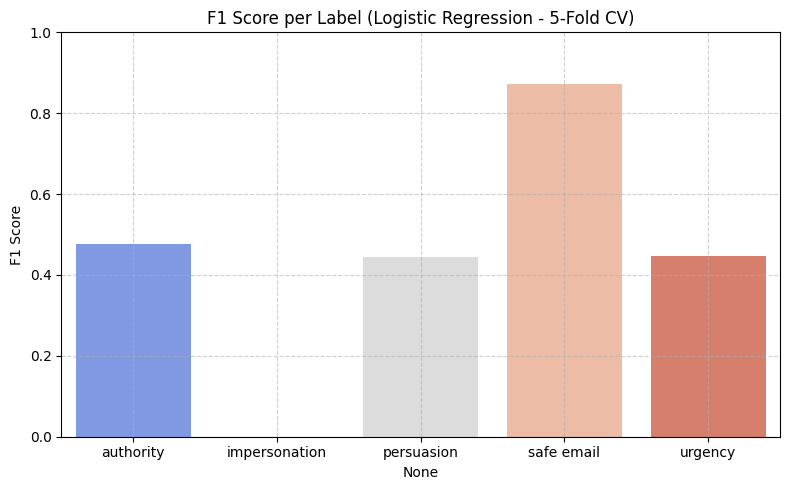

In [91]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
import pandas as pd

# Modeli tanımla
model_logistic = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Cross-validation tahminleri (5-fold)
y_pred_cv = cross_val_predict(model_logistic, X, y, cv=5)

# Sınıflandırma raporu al (etiket başına precision, recall, f1-score)
report = classification_report(y, y_pred_cv, target_names=y.columns, output_dict=True)
# Raporu DataFrame'e çevir
report_df = pd.DataFrame(report).transpose()

# Sadece etiketlere ait olanları filtrele (macro avg, accuracy gibi satırları dışla)
label_f1_scores = report_df.loc[y.columns, "f1-score"]

# Bar grafiğini çiz
plt.figure(figsize=(8, 5))
sns.barplot(x=label_f1_scores.index, y=label_f1_scores.values, palette="coolwarm")
plt.title("F1 Score per Label (Logistic Regression - 5-Fold CV)")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



# RANDOM FOREST

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Modeli tanımla
rf_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))

# Modeli eğit
rf_model.fit(X_train, y_train)

# Tahmin yap
y_pred_rf = rf_model.predict(X_test)

# Performans raporu
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=y.columns))

# Her etiket için doğruluk
for idx, col in enumerate(y.columns):
    acc = accuracy_score(y_test[col], y_pred_rf[:, idx])
    print(f"Accuracy for {col}: {acc:.2f}")


Random Forest Classification Report:

               precision    recall  f1-score   support

    authority       0.98      0.86      0.92       159
impersonation       1.00      0.55      0.71        33
   persuasion       0.99      0.93      0.96       229
   safe email       0.98      0.99      0.99      1009
      urgency       0.99      0.83      0.91       219

    micro avg       0.98      0.94      0.96      1649
    macro avg       0.99      0.83      0.90      1649
 weighted avg       0.98      0.94      0.96      1649
  samples avg       0.97      0.96      0.96      1649

Accuracy for authority: 0.98
Accuracy for impersonation: 0.99
Accuracy for persuasion: 0.99
Accuracy for safe email: 0.98
Accuracy for urgency: 0.98


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-61-1889956689>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_rf, palette="viridis")


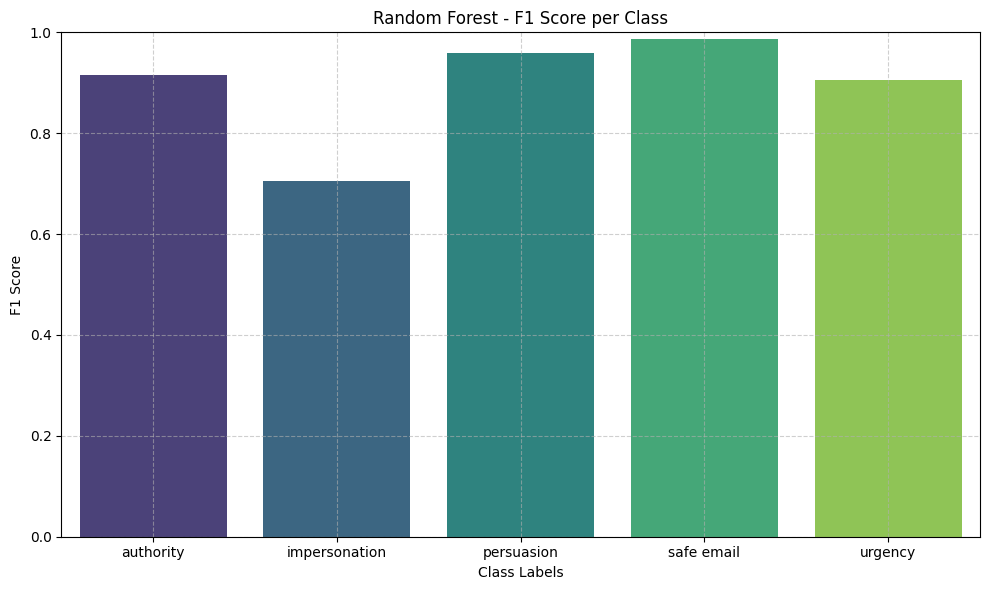

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# Random Forest tahminleri ve gerçek değerler
# y_test ve y_pred_rf zaten var

# Değerlendirme metrikleri (etiket bazında)
precision_rf = precision_score(y_test, y_pred_rf, average=None)
recall_rf = recall_score(y_test, y_pred_rf, average=None)
f1_rf = f1_score(y_test, y_pred_rf, average=None)

labels = y.columns

# F1 skorlarını görselleştir
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=f1_rf, palette="viridis")
plt.title("Random Forest - F1 Score per Class")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.xlabel("Class Labels")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


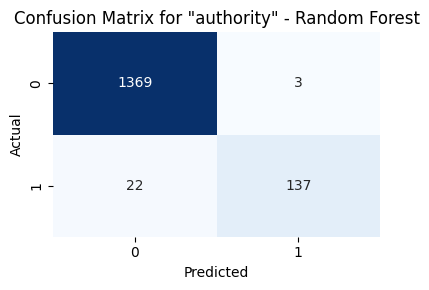

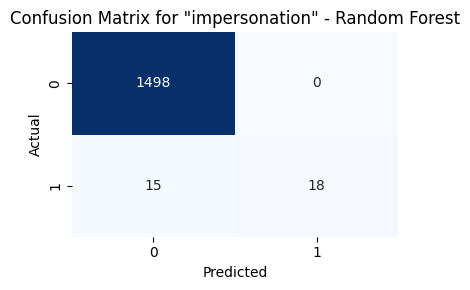

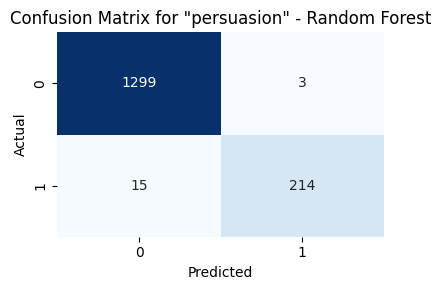

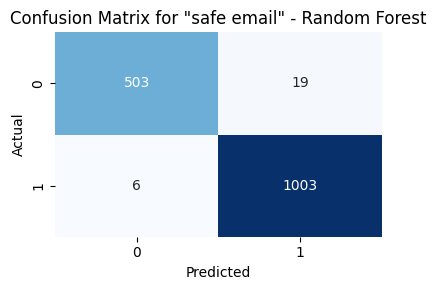

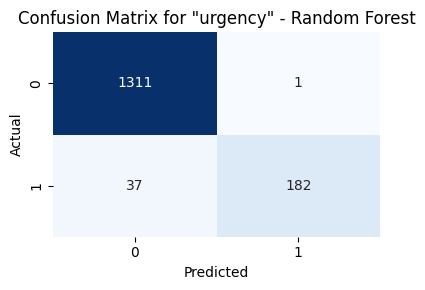

In [62]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# labels zaten y.columns olarak tanımlı
for idx, label in enumerate(labels):
    cm = confusion_matrix(y_test[label], y_pred_rf[:, idx])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for "{label}" - Random Forest')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


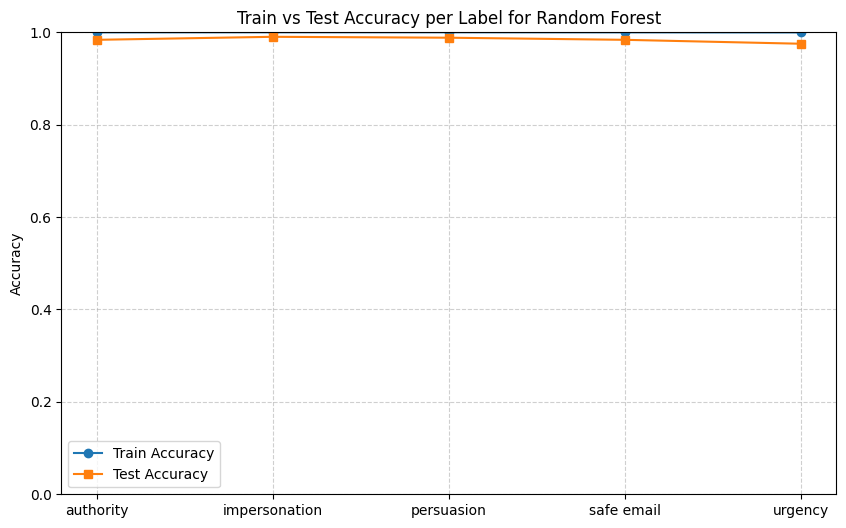

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

def plot_accuracy_line(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    labels = y.columns
    train_acc = []
    test_acc = []

    for idx, label in enumerate(labels):
        train_acc.append(accuracy_score(y_train[label], y_train_pred[:, idx]))
        test_acc.append(accuracy_score(y_test[label], y_test_pred[:, idx]))

    x = np.arange(len(labels))

    plt.figure(figsize=(10,6))
    plt.plot(x, train_acc, marker='o', label='Train Accuracy')
    plt.plot(x, test_acc, marker='s', label='Test Accuracy')

    plt.xticks(x, labels)
    plt.ylim(0,1)
    plt.ylabel('Accuracy')
    plt.title(f'Train vs Test Accuracy per Label for {model_name}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# Random Forest
plot_accuracy_line(rf_model, X_train, y_train, X_test, y_test, "Random Forest")


# LINEAR SVC

In [63]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Modeli tanımla
svc_model = OneVsRestClassifier(LinearSVC(max_iter=10000, random_state=42))

# Modeli eğit
svc_model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yap
y_pred_svc = svc_model.predict(X_test)

# Performans raporu yazdır
print("Linear SVC Classification Report:\n")
print(classification_report(y_test, y_pred_svc, target_names=y.columns))

# Her etiket için doğruluk oranlarını yazdır
for idx, col in enumerate(y.columns):
    acc = accuracy_score(y_test[col], y_pred_svc[:, idx])
    print(f"Accuracy for {col}: {acc:.2f}")


Linear SVC Classification Report:

               precision    recall  f1-score   support

    authority       0.96      0.91      0.93       159
impersonation       0.88      0.91      0.90        33
   persuasion       0.95      0.97      0.96       229
   safe email       0.99      0.99      0.99      1009
      urgency       0.95      0.86      0.90       219

    micro avg       0.97      0.96      0.97      1649
    macro avg       0.95      0.93      0.94      1649
 weighted avg       0.97      0.96      0.97      1649
  samples avg       0.97      0.97      0.97      1649

Accuracy for authority: 0.99
Accuracy for impersonation: 1.00
Accuracy for persuasion: 0.99
Accuracy for safe email: 0.99
Accuracy for urgency: 0.97


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-64-2944335072>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_scores_svc, palette="viridis")


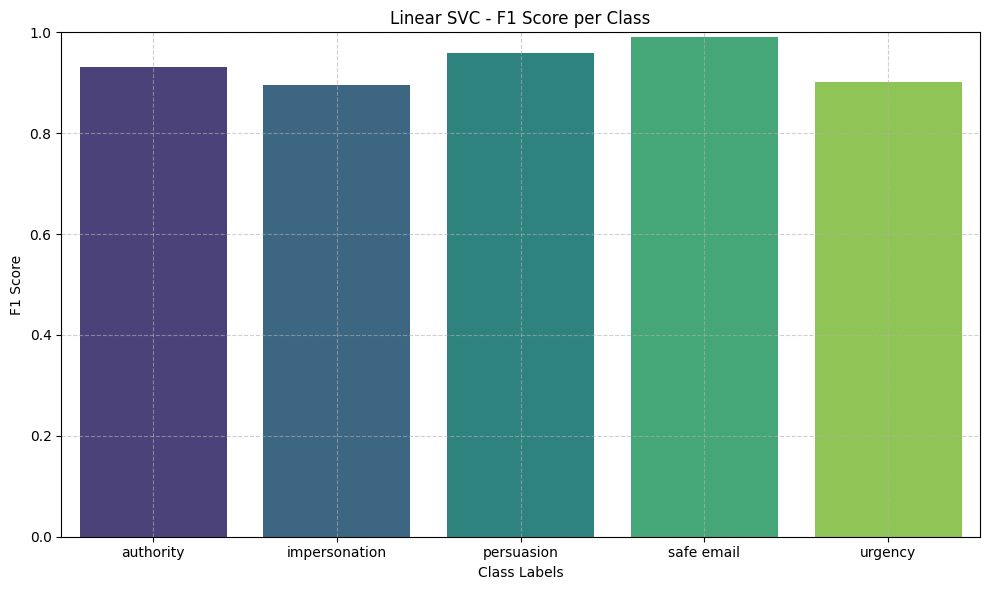

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# F1 skorlarını hesapla
f1_scores_svc = f1_score(y_test, y_pred_svc, average=None)

labels = y.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=f1_scores_svc, palette="viridis")
plt.title("Linear SVC - F1 Score per Class")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.xlabel("Class Labels")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()




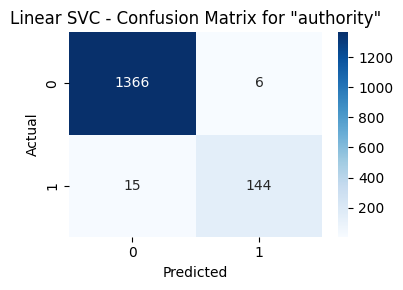

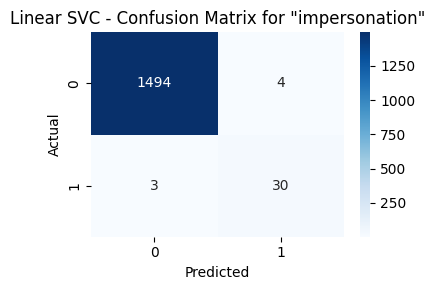

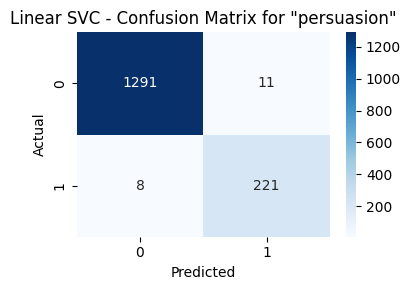

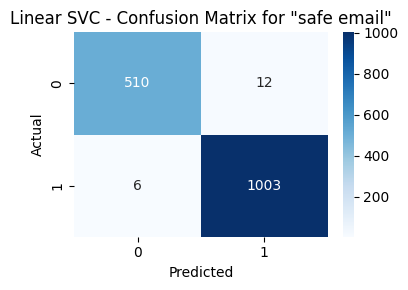

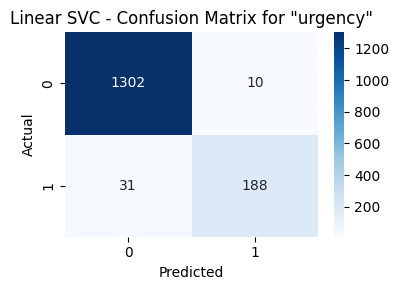

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = y.columns

for idx, label in enumerate(labels):
    cm = confusion_matrix(y_test[label], y_pred_svc[:, idx])

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Linear SVC - Confusion Matrix for "{label}"')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


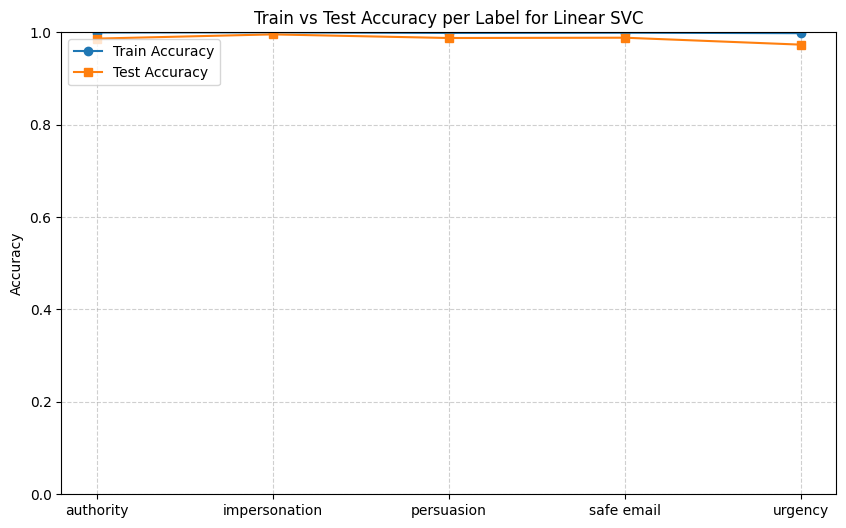

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

def plot_accuracy_line(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    labels = y.columns
    train_acc = []
    test_acc = []

    for idx, label in enumerate(labels):
        train_acc.append(accuracy_score(y_train[label], y_train_pred[:, idx]))
        test_acc.append(accuracy_score(y_test[label], y_test_pred[:, idx]))

    x = np.arange(len(labels))

    plt.figure(figsize=(10,6))
    plt.plot(x, train_acc, marker='o', label='Train Accuracy')
    plt.plot(x, test_acc, marker='s', label='Test Accuracy')

    plt.xticks(x, labels)
    plt.ylim(0,1)
    plt.ylabel('Accuracy')
    plt.title(f'Train vs Test Accuracy per Label for {model_name}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# Linear SVC
plot_accuracy_line(svc_model, X_train, y_train, X_test, y_test, "Linear SVC")


# MULTINOMIAL NAIVE BAYES

In [66]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Multinomial Naive Bayes modeli tanımla
nb_model = OneVsRestClassifier(MultinomialNB())

# Modeli eğit
nb_model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yap
y_pred_nb = nb_model.predict(X_test)

# Performans raporu yazdır
print("Multinomial Naive Bayes Classification Report:\n")
print(classification_report(y_test, y_pred_nb, target_names=y.columns))

# Her etiket için doğruluk oranlarını yazdır
for idx, col in enumerate(y.columns):
    acc = accuracy_score(y_test[col], y_pred_nb[:, idx])
    print(f"Accuracy for {col}: {acc:.2f}")


Multinomial Naive Bayes Classification Report:

               precision    recall  f1-score   support

    authority       0.89      0.75      0.82       159
impersonation       1.00      0.03      0.06        33
   persuasion       0.93      0.88      0.91       229
   safe email       0.98      0.98      0.98      1009
      urgency       0.93      0.71      0.81       219

    micro avg       0.96      0.89      0.92      1649
    macro avg       0.95      0.67      0.71      1649
 weighted avg       0.96      0.89      0.91      1649
  samples avg       0.92      0.91      0.91      1649

Accuracy for authority: 0.96
Accuracy for impersonation: 0.98
Accuracy for persuasion: 0.97
Accuracy for safe email: 0.97
Accuracy for urgency: 0.95


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-67-414944765>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_scores_nb, palette="viridis")


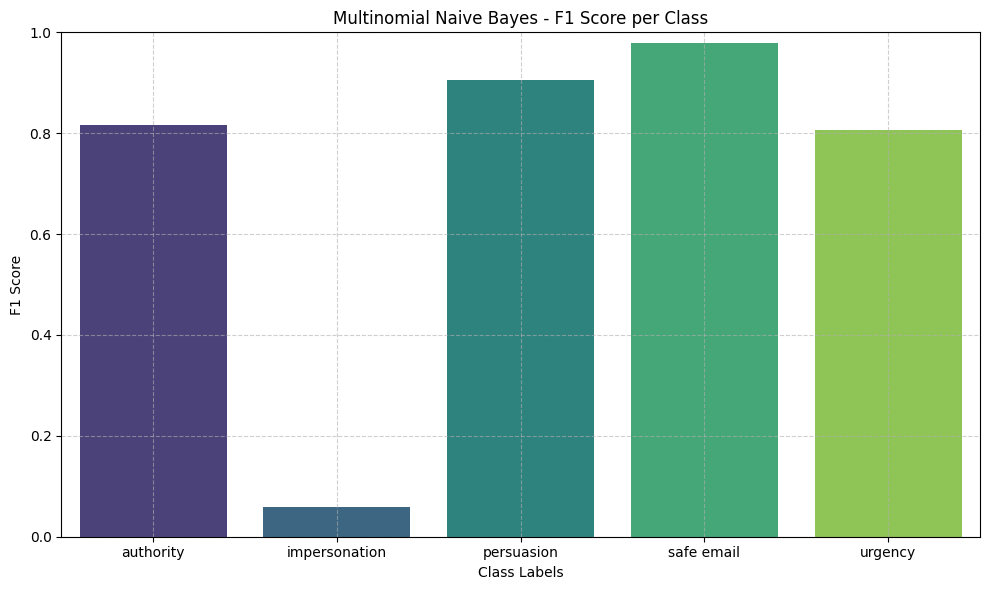

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# F1 skorlarını hesapla
f1_scores_nb = f1_score(y_test, y_pred_nb, average=None)

labels = y.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=f1_scores_nb, palette="viridis")
plt.title("Multinomial Naive Bayes - F1 Score per Class")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.xlabel("Class Labels")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


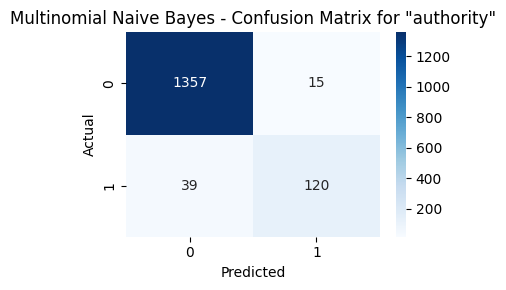

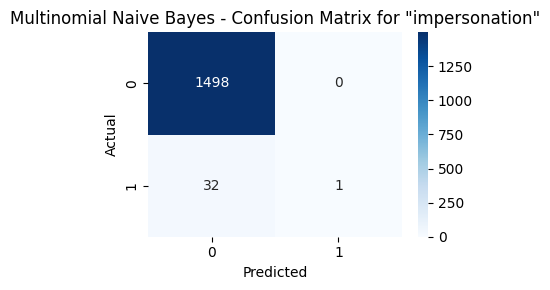

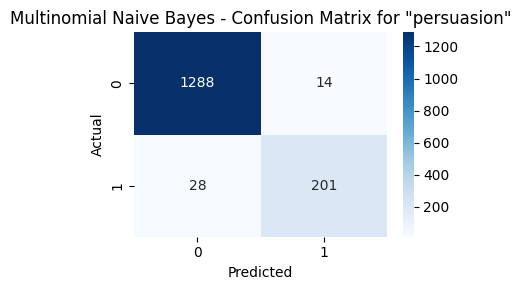

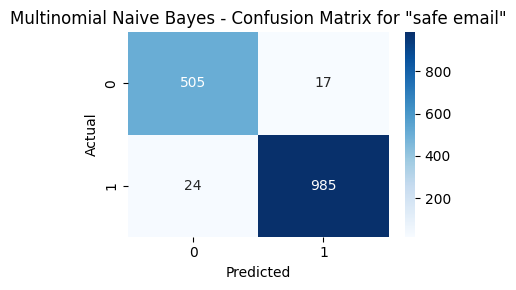

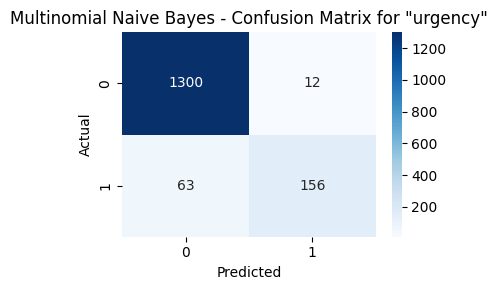

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = y.columns

for idx, label in enumerate(labels):
    cm = confusion_matrix(y_test[label], y_pred_nb[:, idx])

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Multinomial Naive Bayes - Confusion Matrix for "{label}"')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


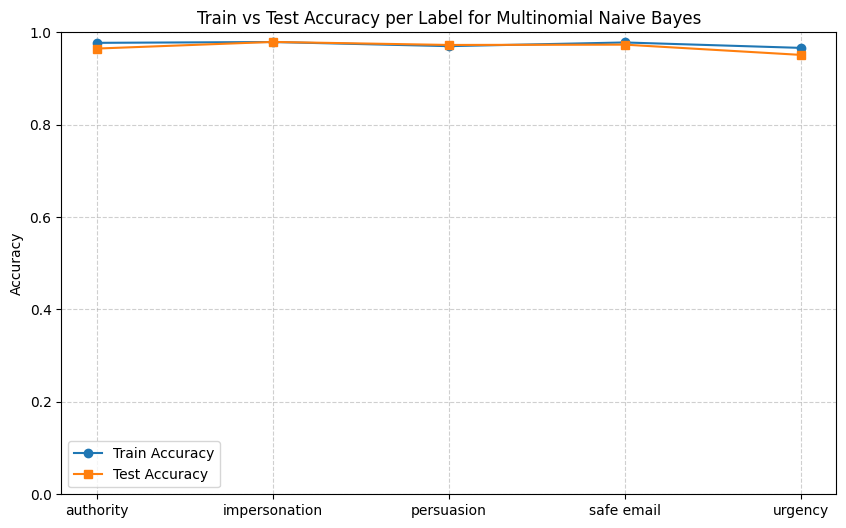

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

def plot_accuracy_line(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    labels = y.columns
    train_acc = []
    test_acc = []

    for idx, label in enumerate(labels):
        train_acc.append(accuracy_score(y_train[label], y_train_pred[:, idx]))
        test_acc.append(accuracy_score(y_test[label], y_test_pred[:, idx]))

    x = np.arange(len(labels))

    plt.figure(figsize=(10,6))
    plt.plot(x, train_acc, marker='o', label='Train Accuracy')
    plt.plot(x, test_acc, marker='s', label='Test Accuracy')

    plt.xticks(x, labels)
    plt.ylim(0,1)
    plt.ylabel('Accuracy')
    plt.title(f'Train vs Test Accuracy per Label for {model_name}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# Multinomial Naive Bayes
plot_accuracy_line(nb_model, X_train, y_train, X_test, y_test, "Multinomial Naive Bayes")


# KARŞILAŞTIRMA

In [69]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Model tahminleri (daha önce ürettiğin sonuçlar)
# y_pred_logistic, y_pred_svc, y_pred_nb, y_pred_rf (Random Forest için modeli eğittiysen)

# Model isimleri
model_names = ['Logistic Regression', 'Multinomial NB', 'Random Forest']

# Tahminler listesi
all_predictions = [y_pred, y_pred_nb, y_pred_rf]

# Boş DataFrame oluştur
metrics_df = pd.DataFrame(columns=['Model', 'Label', 'Precision', 'Recall', 'F1', 'Accuracy'])

for model_name, preds in zip(model_names, all_predictions):
    for idx, label in enumerate(y.columns):
        precision = precision_score(y_test[label], preds[:, idx])
        recall = recall_score(y_test[label], preds[:, idx])
        f1 = f1_score(y_test[label], preds[:, idx])
        accuracy = accuracy_score(y_test[label], preds[:, idx])

        metrics_df = pd.concat([metrics_df, pd.DataFrame([{
            'Model': model_name,
            'Label': label,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Accuracy': accuracy
        }])], ignore_index=True)

# Ortalama metrikler
avg_metrics = metrics_df.groupby('Model')[['Precision', 'Recall', 'F1', 'Accuracy']].mean().reset_index()

print(avg_metrics)

                 Model  Precision    Recall        F1  Accuracy
0  Logistic Regression   0.958308  0.734459  0.815833  0.970738
1       Multinomial NB   0.947076  0.670258  0.713274  0.968125
2        Random Forest   0.988138  0.833338  0.895015  0.984193


<ipython-input-69-2231122342>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([{


<ipython-input-70-4019744763>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=avg_metrics, palette='Set2')
<ipython-input-70-4019744763>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=avg_metrics, palette='Set2')
<ipython-input-70-4019744763>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=avg_metrics, palette='Set2')
<ipython-input-70-4019744763>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

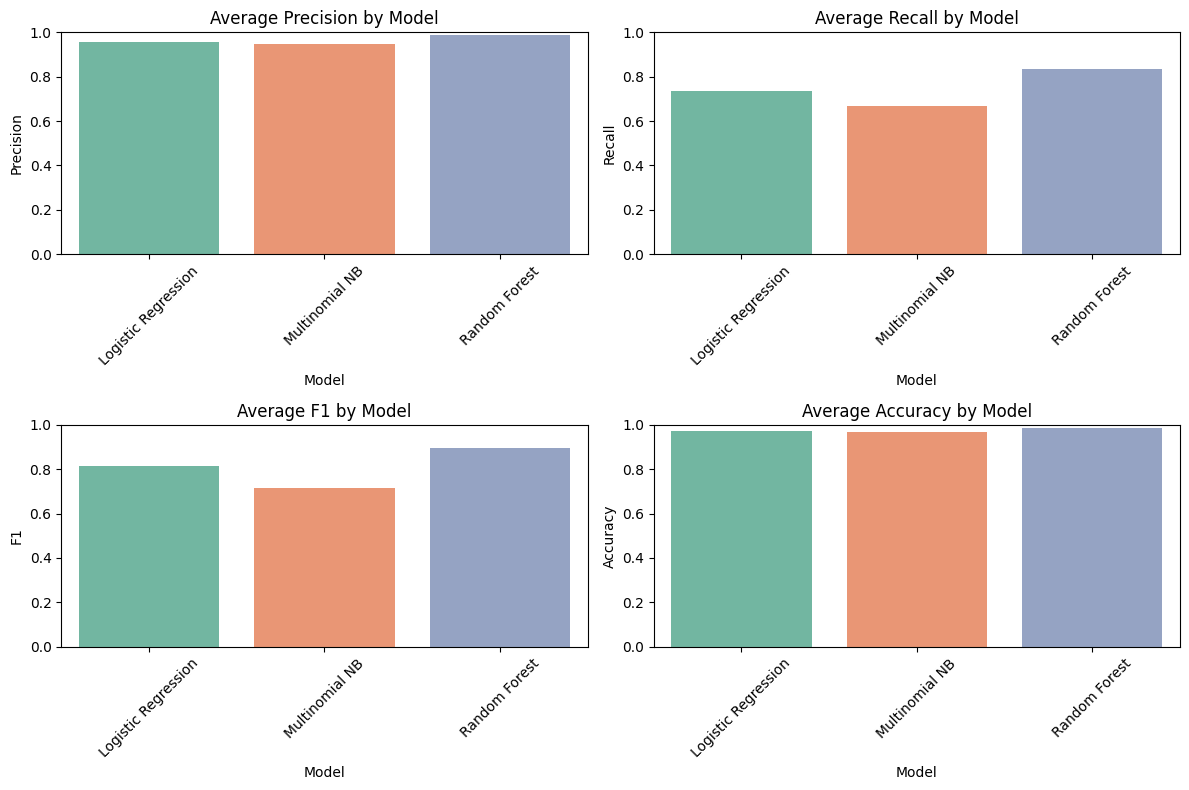

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
metrics_to_plot = ['Precision', 'Recall', 'F1', 'Accuracy']

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=avg_metrics, palette='Set2')
    plt.title(f'Average {metric} by Model')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


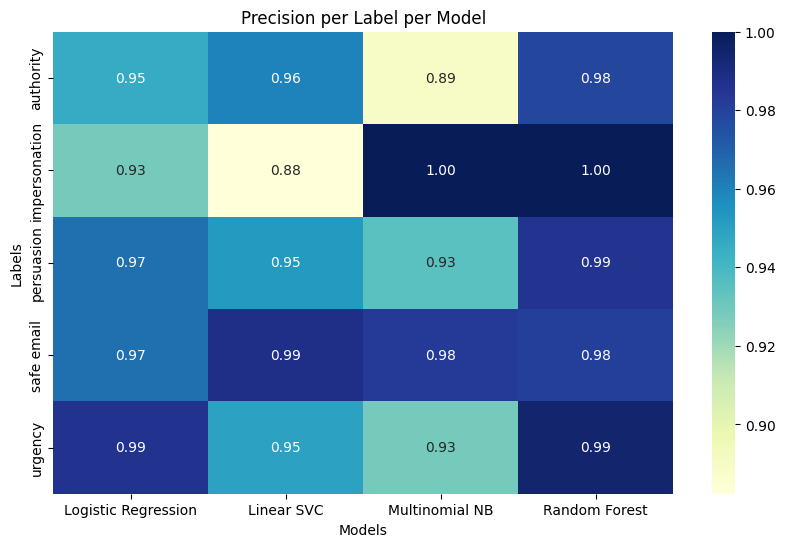

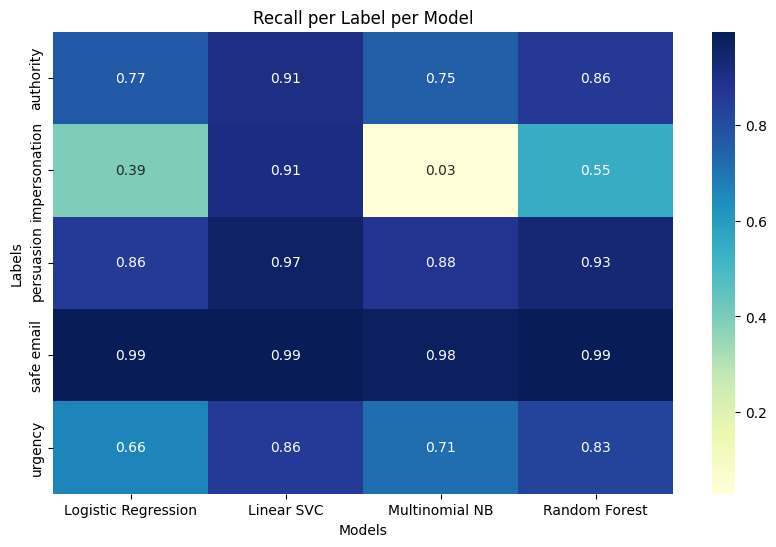

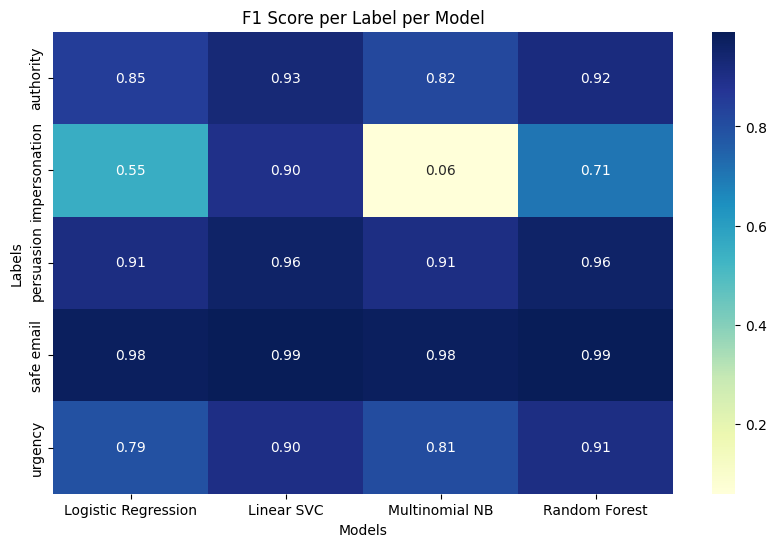

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

model_names = ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Random Forest']
all_predictions = [y_pred, y_pred_svc, y_pred_nb, y_pred_rf]

# Boş sözlükler oluşturuyoruz
precision_dict = {}
recall_dict = {}
f1_dict = {}

for model_name, preds in zip(model_names, all_predictions):
    precisions = []
    recalls = []
    f1s = []
    for idx, label in enumerate(y.columns):
        precisions.append(precision_score(y_test[label], preds[:, idx]))
        recalls.append(recall_score(y_test[label], preds[:, idx]))
        f1s.append(f1_score(y_test[label], preds[:, idx]))
    precision_dict[model_name] = precisions
    recall_dict[model_name] = recalls
    f1_dict[model_name] = f1s

# DataFrame oluştur
precision_df = pd.DataFrame(precision_dict, index=y.columns)
recall_df = pd.DataFrame(recall_dict, index=y.columns)
f1_df = pd.DataFrame(f1_dict, index=y.columns)

# Heatmap çizimi fonksiyonu
def plot_heatmap(df, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title(title)
    plt.ylabel('Labels')
    plt.xlabel('Models')
    plt.show()

# Heatmap'leri çiz
plot_heatmap(precision_df, 'Precision per Label per Model')
plot_heatmap(recall_df, 'Recall per Label per Model')
plot_heatmap(f1_df, 'F1 Score per Label per Model')


In [74]:
from sklearn.metrics import accuracy_score, f1_score

def check_overfit(model, X_train, y_train, X_test, y_test, model_name):
    # Train üzerindeki tahmin
    y_train_pred = model.predict(X_train)

    # Test üzerindeki tahmin
    y_test_pred = model.predict(X_test)

    print(f"--- {model_name} ---")

    for idx, label in enumerate(y.columns):
        train_acc = accuracy_score(y_train[label], y_train_pred[:, idx])
        test_acc = accuracy_score(y_test[label], y_test_pred[:, idx])
        train_f1 = f1_score(y_train[label], y_train_pred[:, idx])
        test_f1 = f1_score(y_test[label], y_test_pred[:, idx])

        print(f"{label}: Train Acc = {train_acc:.3f}, Test Acc = {test_acc:.3f}, Train F1 = {train_f1:.3f}, Test F1 = {test_f1:.3f}")
    print("\n")

# Örnek kullanım:
check_overfit(model, X_train, y_train, X_test, y_test, "Logistic Regression")
check_overfit(svc_model, X_train, y_train, X_test, y_test, "Linear SVC")
check_overfit(nb_model, X_train, y_train, X_test, y_test, "Multinomial Naive Bayes")
check_overfit(rf_model, X_train, y_train, X_test, y_test, "Random Forest")


--- Logistic Regression ---
authority: Train Acc = 0.985, Test Acc = 0.971, Train F1 = 0.916, Test F1 = 0.847
impersonation: Train Acc = 0.990, Test Acc = 0.986, Train F1 = 0.719, Test F1 = 0.553
persuasion: Train Acc = 0.977, Test Acc = 0.974, Train F1 = 0.916, Test F1 = 0.907
safe email: Train Acc = 0.985, Test Acc = 0.972, Train F1 = 0.989, Test F1 = 0.979
urgency: Train Acc = 0.962, Test Acc = 0.950, Train F1 = 0.817, Test F1 = 0.792


--- Linear SVC ---
authority: Train Acc = 1.000, Test Acc = 0.986, Train F1 = 0.997, Test F1 = 0.932
impersonation: Train Acc = 1.000, Test Acc = 0.995, Train F1 = 0.996, Test F1 = 0.896
persuasion: Train Acc = 0.999, Test Acc = 0.988, Train F1 = 0.995, Test F1 = 0.959
safe email: Train Acc = 0.999, Test Acc = 0.988, Train F1 = 0.999, Test F1 = 0.991
urgency: Train Acc = 0.998, Test Acc = 0.973, Train F1 = 0.992, Test F1 = 0.902


--- Multinomial Naive Bayes ---
authority: Train Acc = 0.977, Test Acc = 0.965, Train F1 = 0.870, Test F1 = 0.816
imperso

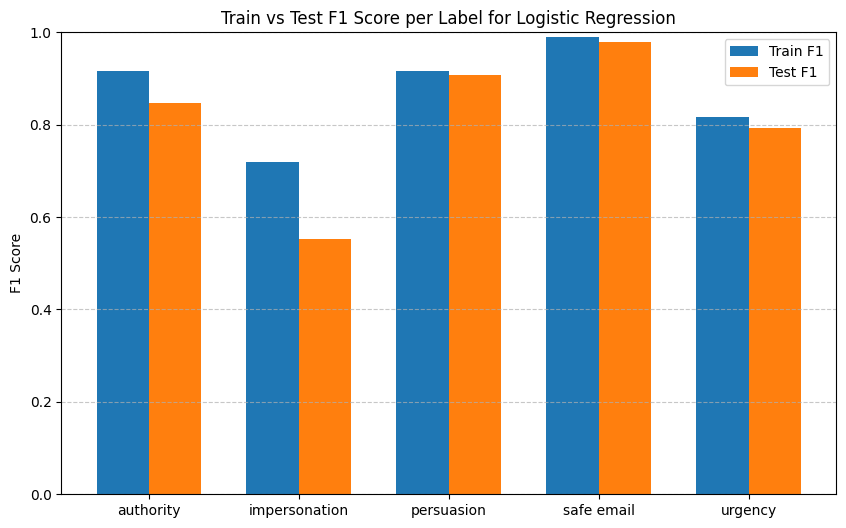

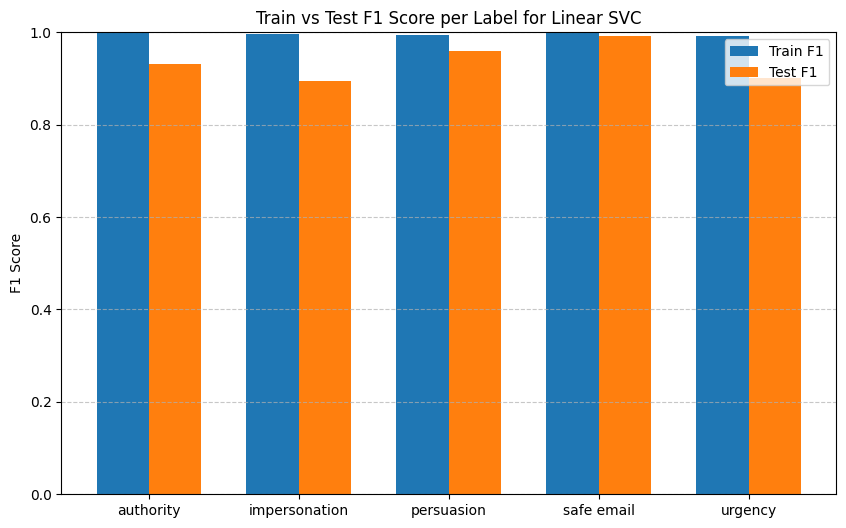

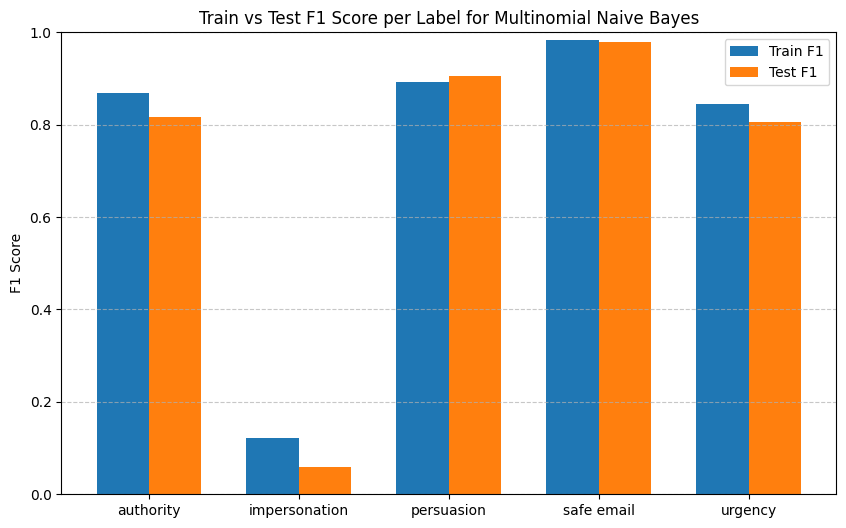

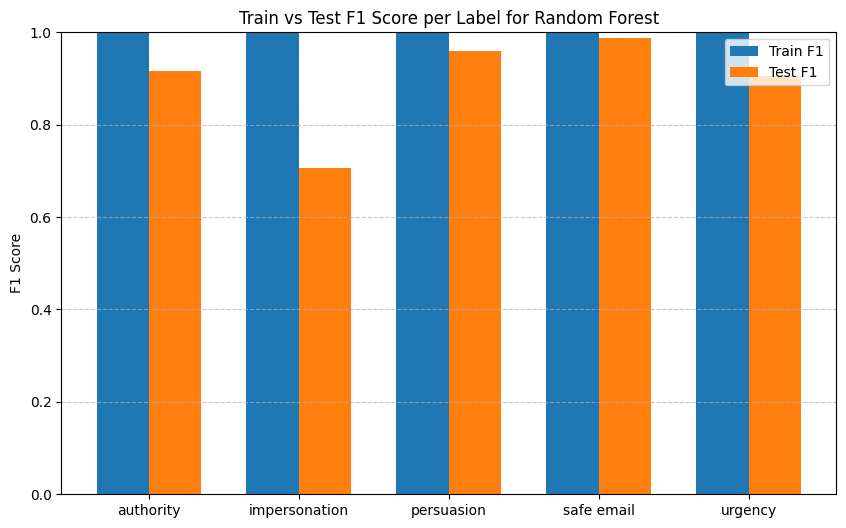

In [75]:
import matplotlib.pyplot as plt
import numpy as np

def plot_overfit_bar(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    labels = y.columns
    train_f1 = []
    test_f1 = []

    for idx, label in enumerate(labels):
        train_f1.append(f1_score(y_train[label], y_train_pred[:, idx]))
        test_f1.append(f1_score(y_test[label], y_test_pred[:, idx]))

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, train_f1, width, label='Train F1')
    plt.bar(x + width/2, test_f1, width, label='Test F1')

    plt.xticks(x, labels)
    plt.ylim(0,1)
    plt.ylabel('F1 Score')
    plt.title(f'Train vs Test F1 Score per Label for {model_name}')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Örnek kullanım:
plot_overfit_bar(model, X_train, y_train, X_test, y_test, "Logistic Regression")
plot_overfit_bar(svc_model, X_train, y_train, X_test, y_test, "Linear SVC")
plot_overfit_bar(nb_model, X_train, y_train, X_test, y_test, "Multinomial Naive Bayes")
plot_overfit_bar(rf_model, X_train, y_train, X_test, y_test, "Random Forest")


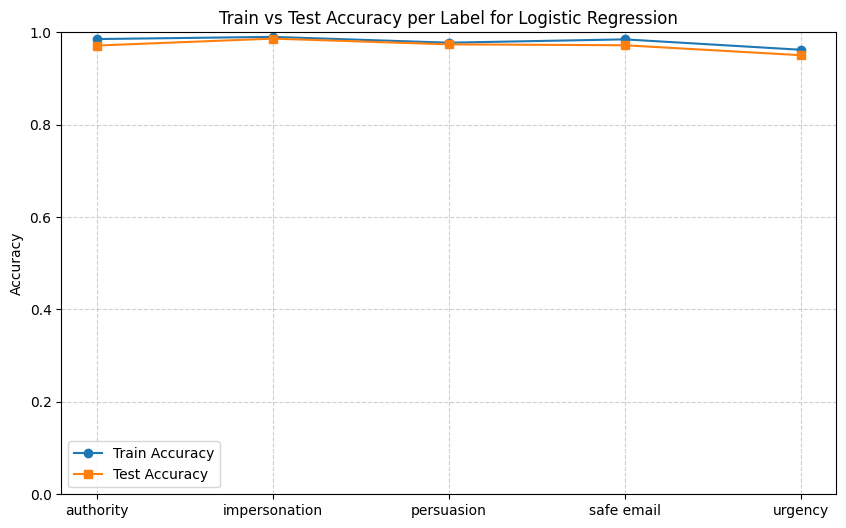

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

def plot_accuracy_line(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    labels = y.columns
    train_acc = []
    test_acc = []

    for idx, label in enumerate(labels):
        train_acc.append(accuracy_score(y_train[label], y_train_pred[:, idx]))
        test_acc.append(accuracy_score(y_test[label], y_test_pred[:, idx]))

    x = np.arange(len(labels))

    plt.figure(figsize=(10,6))
    plt.plot(x, train_acc, marker='o', label='Train Accuracy')
    plt.plot(x, test_acc, marker='s', label='Test Accuracy')

    plt.xticks(x, labels)
    plt.ylim(0,1)
    plt.ylabel('Accuracy')
    plt.title(f'Train vs Test Accuracy per Label for {model_name}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# Kullanımı:
plot_accuracy_line(model, X_train, y_train, X_test, y_test, "Logistic Regression")


# AYRI KALACAK ŞİMDİLİK

BURASI AYRI KALSIN ŞİMDİLİK